<a href="https://colab.research.google.com/github/Pavel-Pyvovar/ml_iasa_2020/blob/master/ml_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Представити початковi данi графiчно.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns
from tqdm import tqdm

sns.set()
%matplotlib inline
np.set_printoptions(linewidth=100)
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.max_colwidth', 100)
print = pprint

In [69]:
plt.rcParams['figure.figsize']

[6.0, 4.0]

In [0]:
plt.rcParams['figure.figsize'] = [12, 8]

In [0]:
# plt.rcParams.update(plt.rcParamsDefault)

In [0]:
iris = sns.load_dataset('iris')

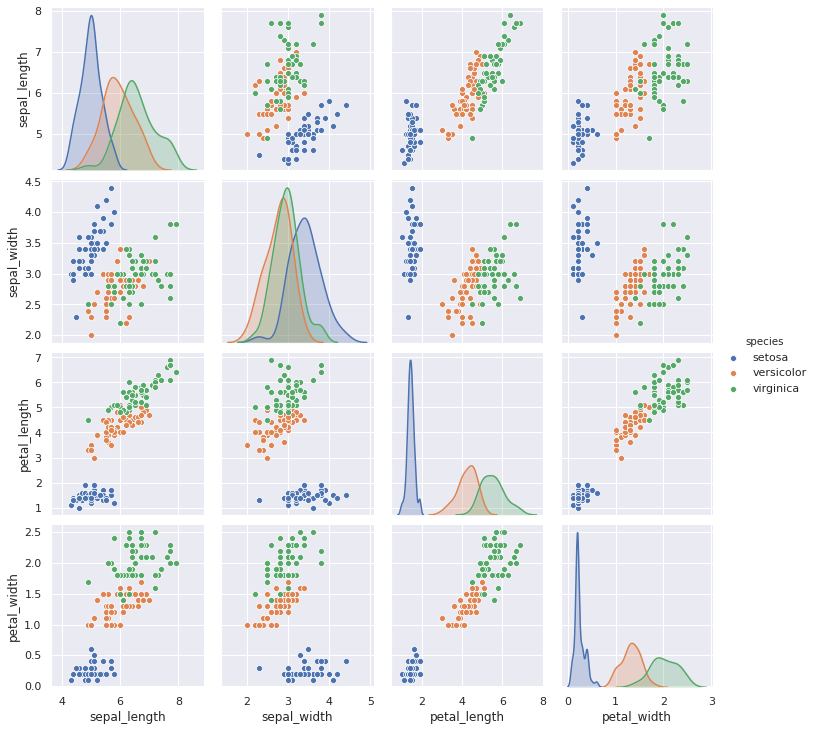

In [73]:
sns.pairplot(iris, hue='species')
plt.show()

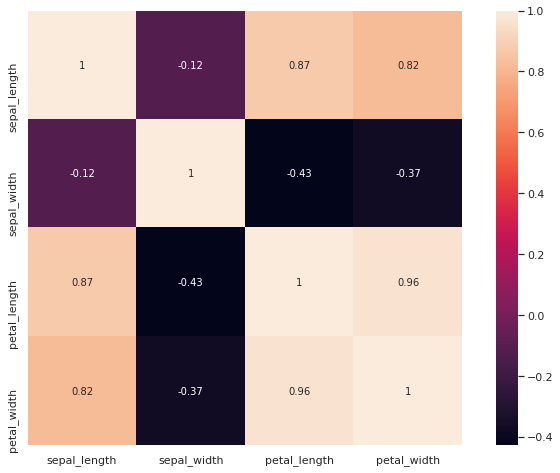

In [74]:
sns.heatmap(iris.corr(), annot=True, cbar=True, square=True)
plt.show()

In [0]:
from sklearn.datasets import make_blobs
X_gen, y_gen = make_blobs(n_samples=400, centers=4, 
                          cluster_std=.6, random_state=0)
rng = np.random.RandomState(13)
X_strached = np.dot(X_gen, rng.randn(2, 2))

# 2. Розбити данi на навчальний i перевiрочний набори.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

data = iris.drop('species', axis=1)
target = iris.species

scaler = StandardScaler()
iris_normalized = scaler.fit_transform(data)

encoder = LabelEncoder()
iris_y_numeric = encoder.fit_transform(target)

scaler = StandardScaler()
X_strached_norm = scaler.fit_transform(X_strached)

data_sets = [train_test_split(iris_normalized, iris_y_numeric),
            train_test_split(X_strached_norm, y_gen)]

#3. Побудувати моделi класифiкацiї або регресiї згiдно з варiантом.
#4.Представити моделi графiчно.
#5. Виконати прогнози на основi моделей.

Побудувати:
* Моделi `sklearn.svm.LinearSVC` та `SVC(kernel="linear")` з лiнiйним ядром, встановити велике значення параметра `С`. При використаннi `LinearSVC` звернути увагу, що навчальнi данi мають бути попередньо масштабованi i центрованi.
* Моделi з лiнiйним ядром i меншими значеннями параметра `С` для даних, якi частково перетинаються.
* Моделi `SVC(kernel="poly")` з полiномiальними ядрами Дослiдити рiзнi ступенi degree та гiперпараметр `coef0` - управляє тим, наскiльки сильно полiноми високого ступеня впливають на модель порiвняно з полiномами низького ступеня.

In [0]:
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,\
                            precision_score, recall_score,\
                            f1_score, precision_recall_curve,\
                            roc_curve, roc_auc_score

iris_classifiers = {'Linear, C=10': SVC(kernel='linear', C=10, probability=True),
                    'LinearSVC, C=10': LinearSVC(C=10, max_iter=5000),
                    'Linear, C=0.1': SVC(kernel='linear', C=.1, probability=True),
                    'Poly, degree=3': SVC(kernel='poly', degree=3, probability=True),
                    'Poly, degree=9': SVC(kernel='poly', degree=9, probability=True),
                    'Poly, degree=27': SVC(kernel='poly', degree=27, probability=True)}

blob_classifiers = {'Linear, C=30': SVC(kernel='linear', C=30, probability=True),
                    'LinearSVC, C=10': LinearSVC(C=10, max_iter=2000),
                    'Linear, C=0.01': SVC(kernel='linear', C=.01, probability=True),
                    'Poly, degree=5': SVC(kernel='poly', degree=5, probability=True),
                    'Poly, degree=9': SVC(kernel='poly', degree=9, probability=True),
                    'Poly, degree=12': SVC(kernel='poly', degree=12, probability=True)}

def ndmeshgrid(X):
    """
    Create coordinate matrices for X
    Params:
        X -- ndarray of shape [n_samples, n_features]
    Returns:
        A sequence of ndarrays. 
    """
    x_min = np.min(X, axis=0) - 1
    x_max = np.max(X, axis=0) + 1
    meshgrid =  np.meshgrid(*(np.arange(a, b, .1) for a, b in zip(x_min, x_max)))
    return meshgrid


def predictions_on_grid(meshgrid, clf):
    """
    Function for making predictions of coordinate 
    matrices produced by ndmeshgrid().
    Params:
        meshrid -- sequence of ndarrays, coordinate matrices.
        clf -- trained classifier to make predictions with.
    Returns:
        y_pred -- vector of predictions.
    """
    x = np.array(list(map(np.ravel, meshgrid))).T
    y_pred = clf.predict(x)
    return y_pred


def render_background(X, y):
    """
    Create a backgound mask for decision boundary using Voronoi tesselation[1].
    If array of samples X is multidimensional it applies dimensionality
    reduction. Then a K-Nearest Neighbours classifier is trained on a lower
    dimensional data. Next, KNN makes predictions on coordinate matrices.
    """
    if X.shape[1] > 2:
        # If X is multidimensional, apply dimensionality reduction.
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)
    
    # Create coordinate matrices for two features.
    meshgrid = ndmeshgrid(X)
    knn = KNeighborsClassifier()
    knn.fit(X, y)
    Z = predictions_on_grid(meshgrid, knn)
    Z = Z.reshape(meshgrid[0].shape)
    return meshgrid, Z, X


def evaluate_model(y_pred, y_true, probas):
    """
    Make a classification report.
    Params:
        y_pred -- ndarray, vector of predictions.
        y_true -- ndarray, vector of true labels.
        probas -- ndarray, vector of probabilities of classes,
                not available for LinearSVC class.
    Returns:
        List of values of each metric.
    """
    metrics =  [accuracy_score(y_pred, y_true),
                confusion_matrix(y_pred, y_true),
                precision_score(y_pred, y_true, average='weighted'),
                recall_score(y_pred, y_true, average='weighted'),
                f1_score(y_pred, y_true, average='weighted')]

    if len(probas) > 0:
        metrics.append(roc_auc_score(y_true, probas, multi_class='ovr'))
    else:
        metrics.append(None)

    return metrics

  
def svm_comparison(classifiers, data_set, show_dicision_boundary=False):
    """
    Compare Support Vector Machine classifiers with different
    parameters (kernel, regularization, polynomial degree).
    The procedure can also plots decision boundaries for test sets
    for each model.

    Parameters:
    classifiers -- dict, keys are model labels, values are instances
                    of classifiers.
    data_set -- tuple of ndarrays. Scaled, encoded and split data set.
                Consists of (X_train, X_test, y_train, y_test).
    show_decision_boundary -- flag to control visualization, default False.
    If set with True, plots decision boundaries for each classifier.

    Returns:
    classifiers = dict, keys are classier names, values are instances of
                    sklearn's SVC or LinearSVC classes.
    train_test_scores -- dict, keys are classier names, values are tuples of
                            the form (train_score, test_score).
    metrics report -- DataFrame, table of evaluated matrics per each classifier. 
    """
    X_train, X_test, y_train, y_test = data_set
    train_test_scores, metrics = {}, {}

    for i, key in tqdm(enumerate(classifiers)):
        # Training the model
        clf = classifiers[key]
        clf.fit(X_train, y_train)

        # Inference
        probas = []
        y_pred = clf.predict(X_test)

        if 'LinearSVC' not in key:
            probas = clf.predict_proba(X_test) 

        metrics[key] = evaluate_model(y_pred, y_test, probas)

        # Evaluate train and test scores to later judge whether overfitting is apperent.
        train_test_scores[key] = clf.score(X_train, y_train), clf.score(X_test, y_test)

        # Visualizing the decision boundary
        meshgrid, Z, X_test_2d = render_background(X_test, y_pred)

        if show_dicision_boundary:
            ax = plt.subplot(2, 3, i+1)
            ax.contourf(meshgrid[0], meshgrid[1], Z)    
            ax.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_pred, cmap='Accent')
            plt.title(key)
            plt.axis('off')

        metrics_report = pd.DataFrame(metrics.values(), index=metrics.keys(),
                                    columns=['accuracy_score',
                                                'confusion_matrix',
                                                'precision_score',
                                                'recall_score',
                                                'f1_score',
                                                'roc_auc_score'])

    return classifiers, train_test_scores, metrics_report

6it [00:01,  4.16it/s]


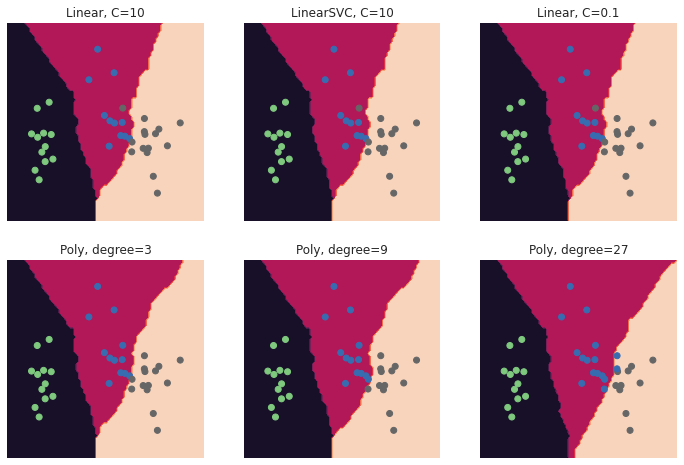

In [78]:
iris_trained_classifiers, iris_train_test_scores, iris_metrics = svm_comparison(iris_classifiers, data_sets[0], True)

1it [00:00,  6.46it/s]/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
2it [00:00,  6.21it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
6it [00:12,  2.08s/it]


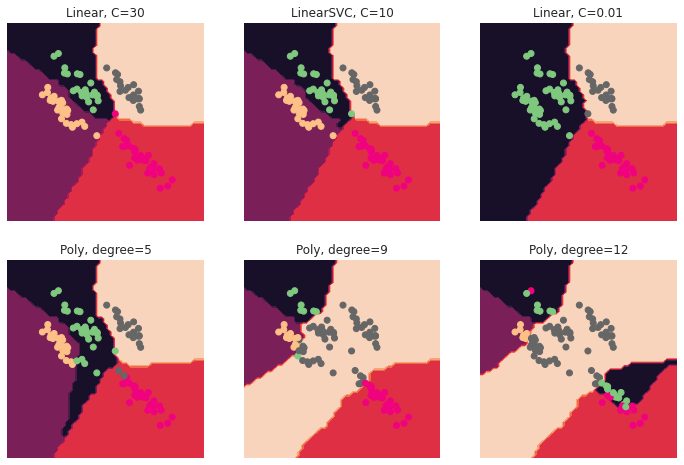

In [79]:
blob_trained_classifiers, blob_train_test_scores, blob_metrics = svm_comparison(classifiers, data_sets[1], True)

#6. Для кожної з моделей оцiнити, чи має мiсце перенавчання.

In [80]:
iris_train_test_scores

{'Linear, C=0.1': (0.9553571428571429, 1.0),
 'Linear, C=10': (0.9642857142857143, 1.0),
 'LinearSVC, C=10': (0.9553571428571429, 1.0),
 'Poly, degree=27': (0.8125, 0.868421052631579),
 'Poly, degree=3': (0.9375, 0.9736842105263158),
 'Poly, degree=9': (0.875, 0.9473684210526315)}

In [81]:
for model in iris_train_test_scores:
    train_score, test_score = iris_train_test_scores[model]
    if np.abs(train_score - test_score) > .03:
        print(f'{model} overfitted')

'Linear, C=10 overfitted'
'LinearSVC, C=10 overfitted'
'Linear, C=0.1 overfitted'
'Poly, degree=3 overfitted'
'Poly, degree=9 overfitted'
'Poly, degree=27 overfitted'


In [82]:
blob_train_test_scores

{'Linear, C=0.01': (0.7366666666666667, 0.72),
 'Linear, C=30': (1.0, 0.99),
 'LinearSVC, C=10': (1.0, 1.0),
 'Poly, degree=12': (0.5233333333333333, 0.45),
 'Poly, degree=5': (0.8966666666666666, 0.94),
 'Poly, degree=9': (0.66, 0.65)}

In [83]:
for model in blob_train_test_scores:
    train_score, test_score = blob_train_test_scores[model]
    if np.abs(train_score - test_score) > .03:
        print(f'{model} overfitted')

'Poly, degree=5 overfitted'
'Poly, degree=12 overfitted'


#7.Розрахувати додатковi результати моделей, наприклад, апостерiорнi iмо-вiрностi, опорнi вектори або iншi (згiдно з варiантом).

Вивести значення опорних векторiв (атрибут `support_vectors_`)
для моделей.

In [0]:
support_vectors = {}
for clf in iris_trained_classifiers:
  if 'LinearSVC' not in clf: 
    # LinearSVC class does not have support_vectors_ attribute
    support_vectors[clf] = iris_trained_classifiers[clf].support_vectors_

In [85]:
print(support_vectors['Linear, C=10'])

array([[-0.90068117,  0.55861082, -1.16971425, -0.92054774],
       [-1.62768839, -1.74335684, -1.39706395, -1.18381211],
       [-1.14301691, -1.51316008, -0.26031542, -0.26238682],
       [ 0.55333328, -1.28296331,  0.64908342,  0.3957741 ],
       [ 1.03800476, -0.13197948,  0.70592084,  0.65903847],
       [-0.29484182, -0.13197948,  0.42173371,  0.3957741 ],
       [ 0.18982966, -0.82256978,  0.76275827,  0.52740629],
       [ 0.55333328,  0.55861082,  0.53540856,  0.52740629],
       [ 0.4321654 , -1.97355361,  0.42173371,  0.3957741 ],
       [ 0.06866179,  0.32841405,  0.59224599,  0.79067065],
       [ 0.31099753, -0.13197948,  0.64908342,  0.79067065],
       [-1.14301691, -1.28296331,  0.42173371,  0.65903847],
       [ 0.18982966, -0.13197948,  0.59224599,  0.79067065],
       [ 0.18982966, -1.97355361,  0.70592084,  0.3957741 ],
       [ 1.64384411, -0.13197948,  1.16062026,  0.52740629],
       [ 0.55333328, -0.59237301,  0.76275827,  0.3957741 ],
       [ 0.4321654 , -0.

# 8. Розрахувати критерiї якостi для кожної моделi:

* матрицю неточностей (confusion matrix),
* точнiсть (precision),
* повноту (recall),
* мiру F1 (F1 score),
* побудувати криву точностi-повноти (precision-recall (PR curve), ROC-криву, показник AUC.

In [86]:
iris_metrics

,accuracy_score,confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score
"Linear, C=10",1.000000,"[[12, 0, 0], [0, 11, 0], [0, 0, 15]]",1.000000,1.000000,1.000000,1.000000
"LinearSVC, C=10",1.000000,"[[12, 0, 0], [0, 11, 0], [0, 0, 15]]",1.000000,1.000000,1.000000,NaN
"Linear, C=0.1",1.000000,"[[12, 0, 0], [0, 11, 0], [0, 0, 15]]",1.000000,1.000000,1.000000,1.000000
"Poly, degree=3",0.973684,"[[12, 0, 0], [0, 11, 1], [0, 0, 14]]",0.975439,0.973684,0.973566,1.000000
"Poly, degree=9",0.947368,"[[12, 0, 0], [0, 11, 2], [0, 0, 13]]",0.954386,0.947368,0.947055,1.000000
"Poly, degree=27",0.868421,"[[12, 0, 0], [0, 11, 5], [0, 0, 10]]",0.912281,0.868421,0.869396,0.868843


In [87]:
blob_metrics

,accuracy_score,confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score
"Linear, C=30",0.99,"[[23, 0, 0, 0], [0, 27, 0, 0], [1, 0, 29, 0], [0, 0, 0, 20]]",0.990417,0.99,0.990022,1.000000
"LinearSVC, C=10",1.00,"[[24, 0, 0, 0], [0, 27, 0, 0], [0, 0, 29, 0], [0, 0, 0, 20]]",1.000000,1.00,1.000000,NaN
"Linear, C=0.01",0.72,"[[23, 27, 0, 0], [0, 0, 0, 0], [0, 0, 29, 0], [1, 0, 0, 20]]",0.979167,0.72,0.805689,0.995869
"Poly, degree=5",0.94,"[[24, 4, 0, 0], [0, 23, 0, 0], [0, 0, 27, 0], [0, 0, 2, 20]]",0.947305,0.94,0.939942,0.993423
"Poly, degree=9",0.65,"[[7, 1, 0, 0], [0, 14, 0, 0], [0, 0, 24, 0], [17, 12, 5, 20]]",0.834547,0.65,0.639860,0.927906
"Poly, degree=12",0.45,"[[6, 0, 13, 0], [0, 8, 0, 0], [1, 0, 11, 0], [17, 19, 5, 20]]",0.726721,0.45,0.455219,0.894644


# 9.Виконати перехресну перевiрку i решiтчатий пошук для пiдбору гiпер-параметрiв моделей.

Настроїти гiперпараметри С та degree за допомогою перехресної
перевiрки.

In [88]:
from sklearn.model_selection import GridSearchCV

iris_train, iris_test, iris_y_train, iris_y_test = data_sets[0]
blob_train, blob_test, blob_y_train, blob_y_test = data_sets[1]

svc = SVC()

param_grid = {'kernel': ['linear', 'poly'],
              'C': [.1, 1, 10, 100],
              'degree': [3, 5, 7]}

iris_svc_gs = GridSearchCV(svc, param_grid, return_train_score=True)
blob_svc_gs = GridSearchCV(svc, param_grid, return_train_score=True)

iris_svc_gs.fit(iris_train, iris_y_train)
blob_svc_gs.fit(blob_train, blob_y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'degree': [3, 5, 7],
                         'kernel': ['linear', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

# 10. Зробити висновки про якiсть роботи моделей на дослiджених даних. Для кожної навчальної вибiрки вибрати найкращу модель.

In [0]:
from sklearn.metrics import classification_report

## Iris data set

In [90]:
iris_svc_results = pd.DataFrame(iris_svc_gs.cv_results_)
iris_svc_results[['param_C', 'param_degree', 'param_kernel',
                  'mean_test_score', 'mean_train_score']].sort_values('mean_test_score')

,param_C,param_degree,param_kernel,mean_test_score,mean_train_score
5,0.1,7,poly,0.759684,0.783471
3,0.1,5,poly,0.777470,0.792434
1,0.1,3,poly,0.803953,0.828140
11,1,7,poly,0.839921,0.874981
9,1,5,poly,0.848221,0.883920
21,100,5,poly,0.875099,0.966517
17,10,7,poly,0.875099,0.908439
23,100,7,poly,0.893676,0.955381
13,10,3,poly,0.929249,0.964295
7,1,3,poly,0.929249,0.941998


In [91]:
iris_svc_gs.best_estimator_

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [92]:
iris_y_pred_gs = iris_svc_gs.predict(iris_test)
report = classification_report(iris_y_test, iris_y_pred_gs, output_dict=True)
pd.DataFrame(report)

,0,1,2,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0,1.0
support,12.0,11.0,15.0,1.0,38.0,38.0


## Blob data set

In [93]:
blob_svc_results = pd.DataFrame(blob_svc_gs.cv_results_)
blob_svc_results[['param_C', 'param_degree', 'param_kernel',
                  'mean_test_score', 'mean_train_score']].sort_values('mean_test_score')

,param_C,param_degree,param_kernel,mean_test_score,mean_train_score
5,0.1,7,poly,0.583333,0.586667
3,0.1,5,poly,0.623333,0.618333
11,1,7,poly,0.683333,0.693333
1,0.1,3,poly,0.776667,0.776667
9,1,5,poly,0.823333,0.855000
17,10,7,poly,0.850000,0.854167
15,10,5,poly,0.903333,0.915000
23,100,7,poly,0.910000,0.914167
7,1,3,poly,0.933333,0.945833
21,100,5,poly,0.960000,0.961667


In [94]:
iris_svc_gs.best_estimator_

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [95]:
iris_y_pred_gs = iris_svc_gs.predict(iris_test)
report = classification_report(iris_y_test, iris_y_pred_gs, output_dict=True)
pd.DataFrame(report)

,0,1,2,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0,1.0
support,12.0,11.0,15.0,1.0,38.0,38.0


#11. Навчити моделi на пiдмножинах навчальних даних. Оцiнити, наскiльки розмiр навчальної множини впливає на якiсть моделi.

In [96]:
for test_size in np.arange(.1, 1, .1):
    lin_svm = LinearSVC()
    X_train, X_test, y_train, y_test = train_test_split(iris_normalized, iris_y_numeric, test_size=test_size)
    lin_svm.fit(X_train, y_train)
    print(f'Test Size: {int(test_size*100)}%, Test Score: {lin_svm.score(X_train, y_train)}, Train Score: {lin_svm.score(X_train, y_train)}')

('Test Size: 10%, Test Score: 0.9481481481481482, Train Score: '
 '0.9481481481481482')
('Test Size: 20%, Test Score: 0.9666666666666667, Train Score: '
 '0.9666666666666667')
('Test Size: 30%, Test Score: 0.9615384615384616, Train Score: '
 '0.9615384615384616')
('Test Size: 40%, Test Score: 0.9444444444444444, Train Score: '
 '0.9444444444444444')
('Test Size: 50%, Test Score: 0.9733333333333334, Train Score: '
 '0.9733333333333334')
'Test Size: 60%, Test Score: 0.95, Train Score: 0.95'
'Test Size: 70%, Test Score: 1.0, Train Score: 1.0'
('Test Size: 80%, Test Score: 0.9666666666666667, Train Score: '
 '0.9666666666666667')
'Test Size: 90%, Test Score: 1.0, Train Score: 1.0'


# References

[1] Migut, M. & Worring, Marcel & Veenman, Cor. (2013). Visualizing multi-dimensional decision boundaries in 2D. Data Mining and Knowledge Discovery. 29. 10.1007/s10618-013-0342-x. 